100%|██████████| 182M/182M [00:22<00:00, 8.04MB/s] 


100%|██████████| 64.3M/64.3M [00:03<00:00, 21.3MB/s]



******************** LoRA Rank: 4 ********************


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 80.9MB/s] 



Epoch 1/5
--------------------------------------------------
Batch 0/916 | Loss: 2.2908 | LR: 0.001000
Batch 20/916 | Loss: 1.8310 | LR: 0.001000
Batch 40/916 | Loss: 1.0130 | LR: 0.001000
Batch 60/916 | Loss: 0.9306 | LR: 0.001000
Batch 80/916 | Loss: 0.9763 | LR: 0.000999
Batch 100/916 | Loss: 0.9152 | LR: 0.000999
Batch 120/916 | Loss: 0.8473 | LR: 0.000998
Batch 140/916 | Loss: 0.9933 | LR: 0.000998
Batch 160/916 | Loss: 0.9576 | LR: 0.000997
Batch 180/916 | Loss: 0.9163 | LR: 0.000996
Batch 200/916 | Loss: 0.8203 | LR: 0.000995
Batch 220/916 | Loss: 0.8620 | LR: 0.000994
Batch 240/916 | Loss: 0.7659 | LR: 0.000993
Batch 260/916 | Loss: 0.7741 | LR: 0.000992
Batch 280/916 | Loss: 0.6564 | LR: 0.000991
Batch 300/916 | Loss: 0.7313 | LR: 0.000989
Batch 320/916 | Loss: 0.7275 | LR: 0.000988
Batch 340/916 | Loss: 0.6883 | LR: 0.000986
Batch 360/916 | Loss: 0.6829 | LR: 0.000985
Batch 380/916 | Loss: 0.6060 | LR: 0.000983
Batch 400/916 | Loss: 0.6915 | LR: 0.000981
Batch 420/916 | Loss

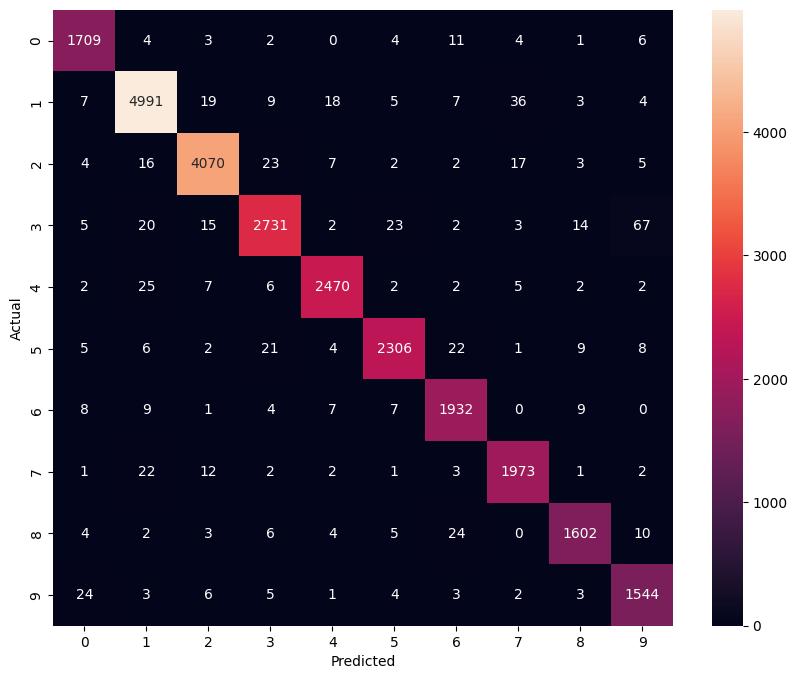

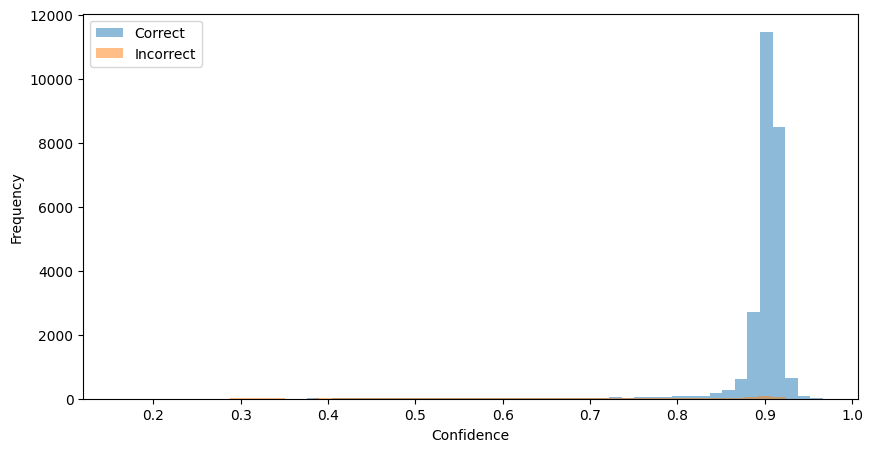


Trainable LoRA Parameters: 442368
Memory Usage: 7498.41 MB
LoRA params contribution: 5.06 MB

******************** LoRA Rank: 1 ********************

Epoch 1/5
--------------------------------------------------
Batch 0/916 | Loss: 2.4997 | LR: 0.001000
Batch 20/916 | Loss: 1.9952 | LR: 0.001000
Batch 40/916 | Loss: 1.1102 | LR: 0.001000
Batch 60/916 | Loss: 1.1106 | LR: 0.001000
Batch 80/916 | Loss: 0.9694 | LR: 0.000999
Batch 100/916 | Loss: 1.0057 | LR: 0.000999
Batch 120/916 | Loss: 1.0116 | LR: 0.000998
Batch 140/916 | Loss: 0.8886 | LR: 0.000998
Batch 160/916 | Loss: 0.9245 | LR: 0.000997
Batch 180/916 | Loss: 0.7354 | LR: 0.000996
Batch 200/916 | Loss: 0.7381 | LR: 0.000995
Batch 220/916 | Loss: 0.8364 | LR: 0.000994
Batch 240/916 | Loss: 0.9581 | LR: 0.000993
Batch 260/916 | Loss: 0.8304 | LR: 0.000992
Batch 280/916 | Loss: 0.8221 | LR: 0.000991
Batch 300/916 | Loss: 0.6497 | LR: 0.000989
Batch 320/916 | Loss: 0.9398 | LR: 0.000988
Batch 340/916 | Loss: 0.7528 | LR: 0.000986
Ba

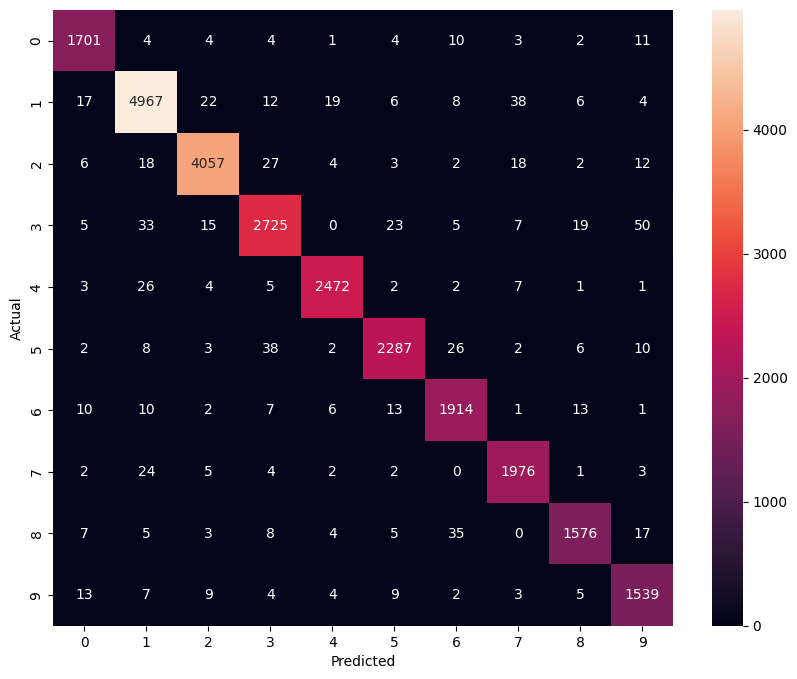

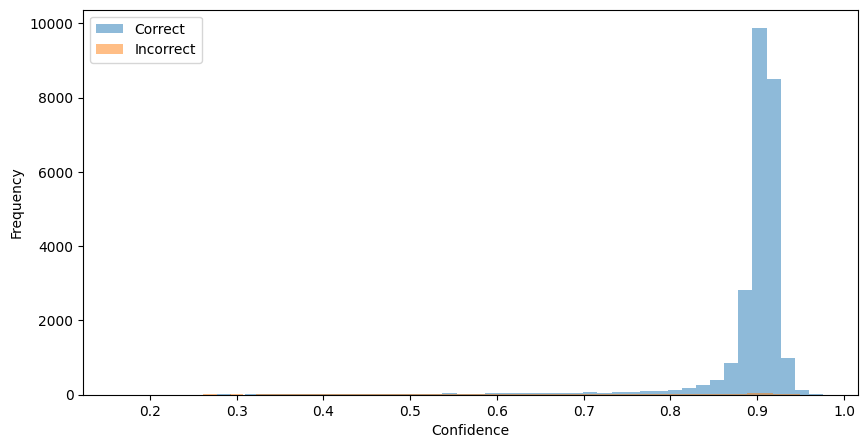


Trainable LoRA Parameters: 110592
Memory Usage: 7490.41 MB
LoRA params contribution: 1.27 MB


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader, random_split
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import math

# ----------------------------
# Hyperparameters & Settings
# ----------------------------
EPOCHS = 5
batch_size = 64
BASE_LR = 1e-3
WEIGHT_DECAY = 0.03
DROPOUT = 0.1
LORA_ALPHA = 32
LORA_DROPOUT = 0.0

R_LORA_VALUES = [ 4, 1]
# ----------------------------
# LoRA Classes and Functions
# ----------------------------
class LoRALayer():
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights

class xLinear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 32,
        lora_dropout: float = 0.0,
        fan_in_fan_out: bool = False,
        merge_weights: bool = True,
        pretrained_weights=None,
        pretrained_bias=None,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        self.fan_in_fan_out = fan_in_fan_out
        if pretrained_weights is not None:
            self.weight.data = pretrained_weights
        if pretrained_bias is not None:
            self.bias.data = pretrained_bias

        # Actual trainable parameters for LoRA
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.scaling = self.lora_alpha / self.r
            self.weight.requires_grad = False
        self._initialize_lora_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.transpose(0, 1)

    def _initialize_lora_parameters(self):
        if hasattr(self, 'lora_A'):
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)
            
    def train(self, mode: bool = True):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if mode:
            if self.merge_weights and self.merged:
                if self.r > 0:
                    self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = False
        else:
            if self.merge_weights and not self.merged:
                if self.r > 0:
                    self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
                self.merged = True

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        if self.r > 0 and not self.merged:
            result = F.linear(x, T(self.weight), bias=self.bias)
            result += (self.lora_dropout(x) @ self.lora_A.transpose(0, 1) @ self.lora_B.transpose(0, 1)) * self.scaling
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)

def replace_linear_with_lora(module: nn.Module, R_LORA, parent_name='', skip_substring='heads.head'):
    """
    Recursively replace all nn.Linear modules with xLinear (LoRA-wrapped Linear)
    while preserving pretrained weights and biases. Skips modules that contain
    the skip_substring in their name.
    """
    for name, child in list(module.named_children()):
        module_path = f"{parent_name}.{name}" if parent_name else name
        replace_linear_with_lora(child, R_LORA, parent_name=module_path, skip_substring=skip_substring)
        if isinstance(child, nn.Linear) and skip_substring not in module_path:
            pretrained_weights = child.weight.data.clone()
            pretrained_bias = child.bias.data.clone() if child.bias is not None else None
            lora_linear = xLinear(
                in_features=child.in_features,
                out_features=child.out_features,
                r=R_LORA,
                lora_alpha=LORA_ALPHA,
                lora_dropout=LORA_DROPOUT,
                pretrained_weights=pretrained_weights,
                pretrained_bias=pretrained_bias,
            )
            setattr(module, name, lora_linear)

def mark_lora_and_head_as_trainable(model: nn.Module, head_substring="heads.head", bias='none'):
    """
    Unfreeze LoRA parameters and the final classification head (matching head_substring)
    while freezing all other parameters.
    """
    for name, param in model.named_parameters():
        if 'lora_' in name:
            param.requires_grad = True
        elif head_substring in name:
            # Uncomment the print statement for debugging if needed
            # print("Unfreezing:", name)
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Optionally unfreeze biases
    if bias == 'all':
        for n, p in model.named_parameters():
            if 'bias' in n:
                p.requires_grad = True
    elif bias == 'lora_only':
        for m in model.modules():
            if isinstance(m, LoRALayer) and hasattr(m, 'bias') and m.bias is not None:
                m.bias.requires_grad = True

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_confidence(model, loader):
    model.eval()
    confidences, correct_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, 1)
            correct = (predicted == labels)
            confidences.extend(max_probs.cpu().numpy())
            correct_labels.extend(correct.cpu().numpy())
    plt.figure(figsize=(10, 5))
    plt.hist([c for c, corr in zip(confidences, correct_labels) if corr],
             bins=50, alpha=0.5, label='Correct')
    plt.hist([c for c, corr in zip(confidences, correct_labels) if not corr],
             bins=50, alpha=0.5, label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_conf_matrix(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = 100.0 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1




# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Preprocessing for SVHN
# ----------------------------
# Get the transforms from the pretrained weights metadata,
# but also add a resize (since SVHN images are 32x32 and ViT expects 224x224)
weights = ViT_B_16_Weights.IMAGENET1K_V1
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# ----------------------------
# Load SVHN Dataset
# ----------------------------
# Download SVHN train and test sets.
# The SVHN dataset has a split argument that can be 'train' or 'test'
train_dataset = SVHN(root='/kaggle/working/train', split='train', transform=preprocess, download=True)
test_dataset  = SVHN(root='/kaggle/working/test', split='test', transform=preprocess, download=True)

# Split training set into training and validation (e.g., 80%-20% split)
val_size = len(train_dataset) // 5
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
loaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# SVHN has 10 classes (digits 0-9)
num_classes = 10

# ----------------------------
# Main Training Loop with LoRA
# ----------------------------
for R_LORA in R_LORA_VALUES:
    print(f"\n{'*'*20} LoRA Rank: {R_LORA} {'*'*20}")

    # Reset peak memory stats (if using GPU)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    # Initialize TensorBoard writer (logs will be saved to logs/svhn/rank_{R_LORA})
    writer = SummaryWriter(f'logs/svhn/rank_{R_LORA}')

    # Initialize ViT model with pretrained weights
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    num_features = model.heads.head.in_features
    # Replace classification head for 10 classes (SVHN digits)
    model.heads.head = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(num_features, num_classes)
    )

    # Apply LoRA to all eligible Linear layers (except the classification head)
    replace_linear_with_lora(model, R_LORA)
    mark_lora_and_head_as_trainable(model)
    model = model.to(device)

    # Set up optimizer, scheduler, and loss criterion
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=BASE_LR,
        weight_decay=WEIGHT_DECAY
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=EPOCHS * len(loaders['train'])
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    best_acc = 0.0
    best_model = None

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 50)
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_preds = []
        train_labels = []

        for batch_idx, (inputs, targets) in enumerate(loaders['train']):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(targets.cpu().numpy())

            if batch_idx % 20 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Batch {batch_idx}/{len(loaders['train'])} | Loss: {loss.item():.4f} | LR: {current_lr:.6f}")

        # Compute epoch statistics
        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # Validation evaluation
        val_loss, val_acc, val_f1 = evaluate(model, loaders['val'], criterion, device)
        # Test evaluation
        test_loss, test_acc, test_f1 = evaluate(model, loaders['test'], criterion, device)

        # Log statistics to TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Acc/train', train_acc, epoch)
        writer.add_scalar('F1/train', train_f1, epoch)

        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)
        writer.add_scalar('F1/val', val_f1, epoch)

        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Acc/test', test_acc, epoch)
        writer.add_scalar('F1/test', test_f1, epoch)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | F1: {train_f1:.2f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {val_f1:.2f}")
        print(f"Test  Loss: {test_loss:.4f} | Acc: {test_acc:.2f}% | F1: {test_f1:.2f}")

        # Save the best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), f'best_svhn_rank{R_LORA}.pth')

    # Final evaluation with the best model
    test_loss, test_acc, test_f1 = evaluate(best_model, loaders['test'], criterion, device)
    writer.add_scalar('Loss/test_final', test_loss, EPOCHS)
    writer.add_scalar('Acc/test_final', test_acc, EPOCHS)
    writer.add_scalar('F1/test_final', test_f1, EPOCHS)

    print(f"\nFinal Test Performance (SVHN - Rank {R_LORA}):")
    print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}% | F1 Score: {test_f1:.2f}")

    # Additional evaluations: confusion matrix and confidence histograms
    plot_conf_matrix(best_model, loaders['test'])
    evaluate_confidence(best_model, loaders['test'])

    # Print memory stats for LoRA parameters
    lora_params = sum(p.numel() for n, p in best_model.named_parameters() if 'lora_' in n)
    print(f"\nTrainable LoRA Parameters: {lora_params}")
    if torch.cuda.is_available():
        mem_usage = torch.cuda.max_memory_allocated() / 1024**2
        print(f"Memory Usage: {mem_usage:.2f} MB")
        optimizer_memory = (3 * lora_params * 4) / (1024 ** 2)  # 4 bytes per float32, factor 3 for param + moments
        print(f"LoRA params contribution: {optimizer_memory:.2f} MB")

    # Cleanup
    del model, best_model
    torch.cuda.empty_cache()
    writer.close()



In [2]:

import shutil     

# Define the folder to zip and the output zip file
folder_to_zip = "/kaggle/working/logs"
output_zip = "/kaggle/working/logs_backup_SVHN-LoRA_rank_4-1"

# Create a zip archive
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print("Zipping completed:", output_zip + ".zip")
!pip install telebot
import telebot  


API_KEY = "5991202973:AAG8u83Knyd2fDz8x7jJ99UuNa0fKihZWOY"

bot1 = telebot.TeleBot(API_KEY, parse_mode=None)

bot1.send_message(800851598, "chek fgvc code")


Zipping completed: /kaggle/working/logs_backup_SVHN-LoRA_rank_4-1.zip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 10.0 MB/s eta 0:00:00


In [ ]:
h               h